## Ejercicio Nro. 6 - Clustering de documentos

In [1]:
# Objetivo: Medir la similitud entre documentos.
# Tareas: 
# Usar medidas de distancia para encontrar los documentos más relevantes.
# Agrupar documentos similares.
# Utilizar técnicas de visualización para  los grupos de documentos.

## Librerías

In [39]:
packages <- c("rvest", "data.table", "dplyr", "stringr", "robotstxt", "lubridate", "lubridate", "purrr", "ggplot2", 
              "dendextend", "dbscan", "tm", "tidyverse", "tidytext", "proxy", "proxy", "Rtsne", "scatterplot3d",
              "RColorBrewer")

if (length(setdiff(packages, rownames(installed.packages()))) > 0) {
  install.packages(setdiff(packages, rownames(installed.packages())))  
}

library("rvest")
library("data.table")
library("dplyr")
library("stringr")
library("robotstxt")
library("lubridate")
library("purrr")
library("ggplot2")
library("dendextend")
library("dbscan")
library("tm")
library("tidyverse")
library("tidytext")
library("proxy")
library("Rtsne")
library("scatterplot3d")
library("RColorBrewer")

## Se verifica que se pueda descargar información de la página

In [3]:
paths_allowed(
  paths = c("https://www.imdb.com/")
)

 www.imdb.com                      



[1] TRUE

## Variables de interés

In [4]:
# Información que se va a descargar de las páginas
tags <- c("rank", "title", "year", "genre", "summary")

# Se define la cantidad de páginas dentro del sitio que recorro para hacer scraping
numPagina <- 3

# Se crea una lista para guardar temporalmente los datos de cada página
paginas <- list()

## Navegación por página y scraping

In [5]:
# Se recorre cada página, se descarga la información requerida y se realiza la limpieza necesaria
for (n in 1:numPagina) {

  html <- paste0("https://www.imdb.com/list/ls025598828/?st_dt=&mode=detail&page=",n,"&sort=list_order,asc/")
  
  # Se carga la página
  movies <- read_html(html)
  
  # Ranking de películas
  rank <- movies %>% html_nodes(".text-primary") %>% html_text() %>% str_replace_all("[\\s.]+", "")
  
  # Título de las películas
  title <- movies %>% html_nodes(".lister-item-header a") %>% html_text() 
  
  # Año de filmación
  year <- movies %>% html_nodes(".lister-item-year") %>% html_text() %>% str_replace_all("[\\s()]+", "") %>% 
    str_sub(-4) %>% as.numeric()
  
  # Género de las películas
  genre <- movies %>% html_nodes(".genre") %>% html_text()%>% str_replace_all("[\\s()]+", "")
  
  # Sinopsis (es necesario hacer scraping desde 2 elementos distintos)
  summary1  <- movies %>% html_nodes( ".lister-item-content") %>% html_node(".ipl-rating-widget+ p") %>% 
    html_text() %>% str_replace_all("[\\n.()]+", "")
  summary2  <- movies %>% html_nodes( ".lister-item-content") %>% html_node(".ratings-metascore+ p") %>% 
    html_text() %>% str_replace_all("[\\n.()]+", "")
  
  # Junto la información de sinopsis en un elemento
  for (i in 1:100){
    summary1[i] <- ifelse(is.na(summary1[i]), summary2[i], summary1[i] )
  }
  
  #Se crea tabla con variables
  tabla <- data.table(rank, title, year, genre, summary1)
  names(tabla) <- c(tags)
  
  # Si hay celdas vacías se asigna NA
  tabla[tabla == ""] <- NA
  
  # Se guarda información en lista
  paginas[[n]] <- tabla
  
  cat(paste0("Página N° ", n, "... Cantidad de registros: ", nrow(tabla), " ..."), "\n")
}

Página N° 1... Cantidad de registros: 100 ... 
Página N° 2... Cantidad de registros: 100 ... 
Página N° 3... Cantidad de registros: 100 ... 


## Se transforma la lista creada en una tabla única

In [6]:
dataset <- rbindlist(paginas)
head(dataset, 10)

rank,title,year,genre,summary
1,Breaking Bad,2013,"Crime,Drama,Thriller",A high school chemistry teacher diagnosed with inoperable lung cancer turns to manufacturing and selling methamphetamine in order to secure his family's future
2,Crank 2: Alto voltaje,2009,"Action,Thriller",Chelios faces a Chinese mobster who has stolen his nearly indestructible heart and replaced it with a battery-powered ticker which requires regular jolts of electricity to keep working
3,Django sin cadenas,2012,"Drama,Western","With the help of a German bounty hunter, a freed slave sets out to rescue his wife from a brutal Mississippi plantation owner"
4,"Crank, veneno en la sangre",2006,"Action,Crime,Thriller",Professional assassin Chev Chelios learns his rival has injected him with a poison that will kill him if his heart rate drops
5,Sin Control,2014,"Action,Crime,Thriller",An ex-hit-man comes out of retirement to track down the gangsters that killed his dog and took everything from him
6,John Wick 2: Un nuevo día para matar,2017,"Action,Crime,Thriller","After returning to the criminal underworld to repay a debt, John Wick discovers that a large bounty has been put on his life"
7,Amigos de armas,2016,"Biography,Comedy,Crime","Loosely based on the true story of two young men, David Packouz and Efraim Diveroli, who won a three hundred million dollar contract from the Pentagon to arm America's allies in Afghanistan"
8,Los 8 más odiados,2015,"Crime,Drama,Mystery","In the dead of a Wyoming winter, a bounty hunter and his prisoner find shelter in a cabin currently inhabited by a collection of nefarious characters"
9,Una película serbia,2010,"Horror,Mystery,Thriller","An aging porn star agrees to participate in an ""art film"" in order to make a clean break from the business, only to discover that he has been drafted into making a pedophilia and necrophilia themed snuff film"
10,Pecados capitales,1995,"Crime,Drama,Mystery","Two detectives, a rookie and a veteran, hunt a serial killer who uses the seven deadly sins as his motives"


In [7]:
dim(dataset)

[1] 300   5

In [8]:
# Géneros de películas
unique(dataset$genre)

[1] "Crime,Drama,Thriller"          "Action,Thriller"              
  [3] "Drama,Western"                 "Action,Crime,Thriller"        
  [5] "Biography,Comedy,Crime"        "Crime,Drama,Mystery"          
  [7] "Horror,Mystery,Thriller"       "Crime,Drama"                  
  [9] "Biography,Crime,Drama"         "Adventure,Drama,War"          
 [11] "Comedy,Crime,Drama"            "Horror"                       
 [13] "Action,Drama,War"              "Action,Biography,Drama"       
 [15] "Drama,Thriller"                "Comedy,Drama,Sci-Fi"          
 [17] "Action,Crime,Drama"            "Crime,Horror,Thriller"        
 [19] "Comedy,Fantasy"                "Comedy"                       
 [21] "Comedy,Horror"                 "Biography,Drama"              
 [23] "Drama,Fantasy,Horror"          "Mystery,Thriller"             
 [25] "Comedy,Crime"                  "Drama"                        
 [27] "Drama,War"                     "Action,Comedy,Crime"          
 [29] "Adventure,Drama,Romance"       "Biography,Drama,War"          
 [31] "Crime,Horror,Mystery"          "Drama,Music,Romance"          
 [33] "Biography,Comedy,Drama"        "Horror,Mystery,Sci-Fi"        
 [35] "Action,Adventure,Sci-Fi"       "Drama,Horror"                 
 [37] "Drama,Mystery,Sci-Fi"          "Crime,Drama,Sci-Fi"           
 [39] "Mystery,Sci-Fi,Thriller"       "Crime,Drama,Fantasy"          
 [41] "Action,Drama,History"          "Action,Adventure,Comedy"      
 [43] "Horror,Sci-Fi"                 "Western"                      
 [45] "Biography,Drama,Thriller"      "Horror,Thriller"              
 [47] "Adventure,Sci-Fi"              "Action,Drama,Sci-Fi"          
 [49] "Drama,Sci-Fi,Thriller"         "Adventure,Drama,Thriller"     
 [51] "Action,Adventure"              "Action,Sci-Fi"                
 [53] "Crime,Mystery,Thriller"        "Crime,Thriller"               
 [55] "Action,Crime,Horror"           "Horror,Sci-Fi,Thriller"       
 [57] "Action,Adventure,Thriller"     "Adventure,Comedy"             
 [59] "Drama,Horror,Sci-Fi"           "Action,Adventure,Drama"       
 [61] "Adventure,Comedy,Sci-Fi"       "Biography,Drama,Music"        
 [63] "Action,Adventure,Crime"        "Comedy,Crime,Sport"           
 [65] "Drama,Horror,Thriller"         "Drama,Mystery,Thriller"       
 [67] "Adventure,Drama,Fantasy"       "Action,Drama"                 
 [69] "Biography,Drama,History"       "Documentary,Biography,History"
 [71] "Crime,Drama,History"           "Adventure,Comedy,Drama"       
 [73] "Adventure,Drama"               "Action,Comedy,Fantasy"        
 [75] "Fantasy,Horror"                "Horror,Mystery"               
 [77] "Action,Horror,Sci-Fi"          "Animation,Action,Adventure"   
 [79] "Drama,Horror,Music"            "Adventure,Sci-Fi,Thriller"    
 [81] "Biography,Drama,Sport"         "Drama,Fantasy"                
 [83] "Action,Adventure,Horror"       "Adventure,Horror,Thriller"    
 [85] "Action,Adventure,Fantasy"      "Action,Drama,Thriller"        
 [87] "Animation,Adventure,Comedy"    "Drama,Romance"                
 [89] "Adventure,Comedy,Fantasy"      "Animation,Adventure,Drama"    
 [91] "Comedy,Crime,Thriller"         "Comedy,Drama,Music"           
 [93] "Drama,Music"                   "Drama,Horror,Mystery"         
 [95] "Adventure,Horror"              "Action,Comedy,War"            
 [97] "Comedy,Drama"                  "Adventure,Drama,Mystery"      
 [99] "Action,Crime,Sci-Fi"           "Comedy,Romance"               
[101] "Drama,Mystery,War"             "Adventure,Comedy,Music"       
[103] "Adventure,Biography,Drama"     "Comedy,Drama,Thriller"        
[105] "Adventure,Family,Fantasy"      "Comedy,Crime,Mystery"         
[107] "Drama,Thriller,War"            "Action,Sci-Fi,Thriller"       
[109] "Fantasy,Horror,Mystery"        "Drama,Fantasy,War"            
[111] "Sci-Fi,Thriller"               "Drama,Romance,Sci-Fi"         
[113] "Drama,History,Thriller"        "Action,Mystery,Thriller"      
[115] "Comed

## Limpieza inicial

In [9]:
limpiar <- function(texto){
  # Eliminación de páginas web (palabras que empiezan por "http." seguidas 
  # de cualquier cosa que no sea un espacio)
  nuevo_texto <- str_replace_all(texto,"http\\S*", "")
  # Eliminación de signos de puntuación
  nuevo_texto <- str_replace_all(nuevo_texto,"[[:punct:]]", " ")
  # Eliminación de números
  nuevo_texto <- str_replace_all(nuevo_texto,"[[:digit:]]", " ")
  # Eliminación de espacios en blanco múltiples
  nuevo_texto <- str_replace_all(nuevo_texto,"[\\s]+", " ")
  # Se convierte todo el texto a minúsculas
  nuevo_texto <- tolower(nuevo_texto)
  # Elimino palabras vacías
  nuevo_texto <- removeWords(nuevo_texto, stopwords("english"))
  # Steeming
  nuevo_texto <- stemDocument(nuevo_texto, language = "english")
    
  return(nuevo_texto)
}

In [10]:
# Aplico función de limpieza
dataset <- dataset %>% 
    mutate(summary_clean = map(.x = summary, .f = limpiar))

head(dataset[, c("summary", "summary_clean")], 10)

summary,summary_clean
A high school chemistry teacher diagnosed with inoperable lung cancer turns to manufacturing and selling methamphetamine in order to secure his family's future,high school chemistri teacher diagnos inoper lung cancer turn manufactur sell methamphetamin order secur famili s futur
Chelios faces a Chinese mobster who has stolen his nearly indestructible heart and replaced it with a battery-powered ticker which requires regular jolts of electricity to keep working,chelio face chines mobster stolen near indestruct heart replac batteri power ticker requir regular jolt electr keep work
"With the help of a German bounty hunter, a freed slave sets out to rescue his wife from a brutal Mississippi plantation owner",help german bounti hunter freed slave set rescu wife brutal mississippi plantat owner
Professional assassin Chev Chelios learns his rival has injected him with a poison that will kill him if his heart rate drops,profession assassin chev chelio learn rival inject poison will kill heart rate drop
An ex-hit-man comes out of retirement to track down the gangsters that killed his dog and took everything from him,ex hit man come retir track gangster kill dog took everyth
"After returning to the criminal underworld to repay a debt, John Wick discovers that a large bounty has been put on his life",return crimin underworld repay debt john wick discov larg bounti put life
"Loosely based on the true story of two young men, David Packouz and Efraim Diveroli, who won a three hundred million dollar contract from the Pentagon to arm America's allies in Afghanistan",loos base true stori two young men david packouz efraim diveroli won three hundr million dollar contract pentagon arm america s alli afghanistan
"In the dead of a Wyoming winter, a bounty hunter and his prisoner find shelter in a cabin currently inhabited by a collection of nefarious characters",dead wyom winter bounti hunter prison find shelter cabin current inhabit collect nefari charact
"An aging porn star agrees to participate in an ""art film"" in order to make a clean break from the business, only to discover that he has been drafted into making a pedophilia and necrophilia themed snuff film",age porn star agre particip art film order make clean break busi discov draft make pedophilia necrophilia theme snuff film
"Two detectives, a rookie and a veteran, hunt a serial killer who uses the seven deadly sins as his motives",two detect rooki veteran hunt serial killer use seven dead sin motiv


## Corpus

In [11]:
# Armo el corpus
corpus <- Corpus(VectorSource(dataset$summary_clean)) 

# Guardo información para mostar en los clusters
labels <- dataset$title
genres <- dataset$genre

## Matriz DTM

In [12]:
tdm       <- DocumentTermMatrix(corpus) 
tdm_tfidf <- weightTfIdf(tdm)

In [13]:
tdm_tfidf

<<DocumentTermMatrix (documents: 300, terms: 2125)>>
Non-/sparse entries: 4546/632954
Sparsity           : 99%
Maximal term length: 14
Weighting          : term frequency - inverse document frequency (normalized) (tf-idf)

In [14]:
# Se prueban diferentes valores para eliminar términos dispersos
removeSparseTerms(tdm_tfidf, 0.99) 

<<DocumentTermMatrix (documents: 300, terms: 272)>>
Non-/sparse entries: 2026/79574
Sparsity           : 98%
Maximal term length: 12
Weighting          : term frequency - inverse document frequency (normalized) (tf-idf)

In [15]:
tdm_tfidf <- removeSparseTerms(tdm_tfidf, 0.99) 

In [16]:
# Dada la cantidad de términos se decide trabajar con la cantidad obtenida (no se remueven términos dispersos)
tfidf_matrix <- as.matrix(tdm_tfidf) 

In [17]:
dim(tfidf_matrix)

[1] 300 272

## Clustering

In [18]:
# Matriz de distancia (método coseno)
dist_matrix = dist(tfidf_matrix, method = "cosine") 

### Clúster Jerárquico

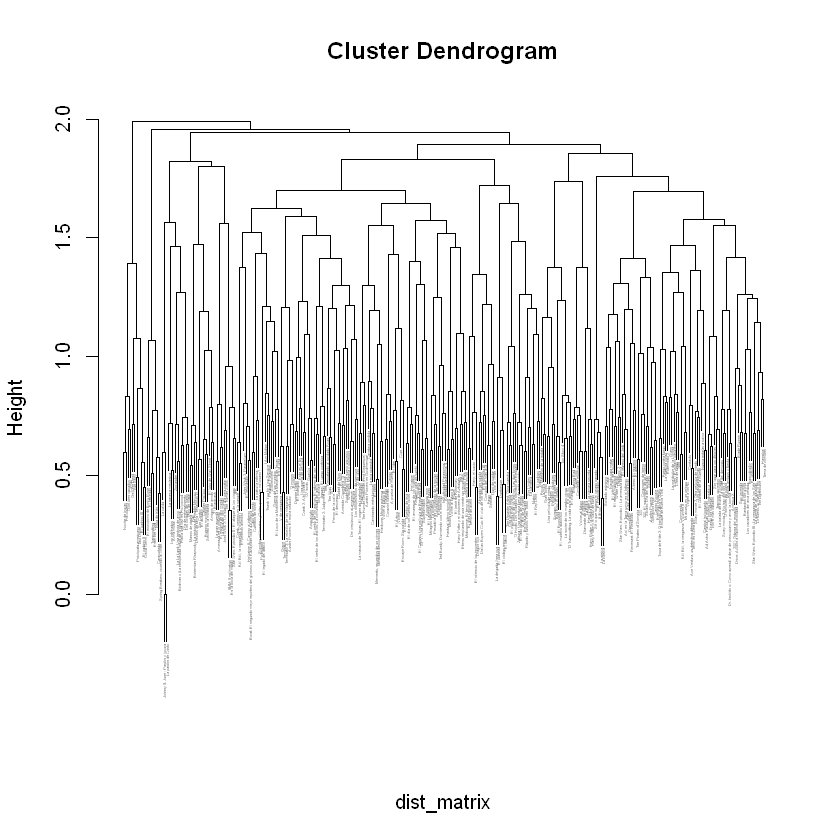

In [19]:
# Se crea el dendograma
hc <- hclust(dist_matrix, method = "ward.D2")
plot(hc, labels = labels, sub = "", cex = 0.2)

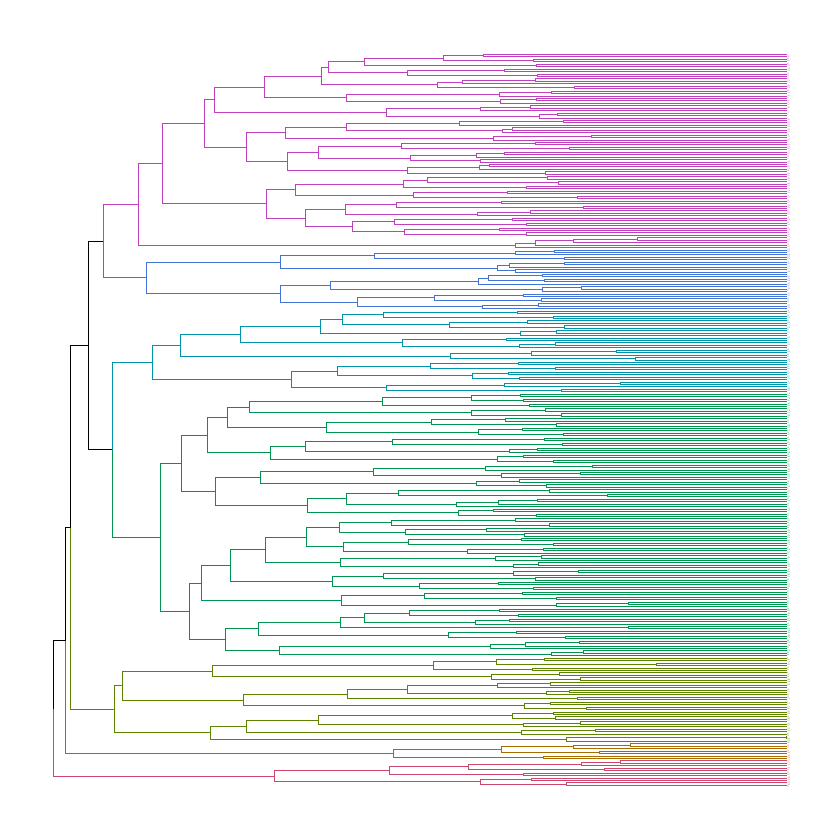

In [20]:
# Se prueba dividir el dendograma en 7 grupos
par(mar=c(1,1,1,1))
as.dendrogram(hc) %>% 
  set("labels_cex", 0.1) %>%
  set("labels_col", k=7) %>%
  set("branches_k_color", k=7) %>%
  plot(horiz=TRUE, axes=FALSE)

Para poder visualizar mejor los grupos se establece un punto de corte en la altura del dendograma y se elige un sub-árbol.

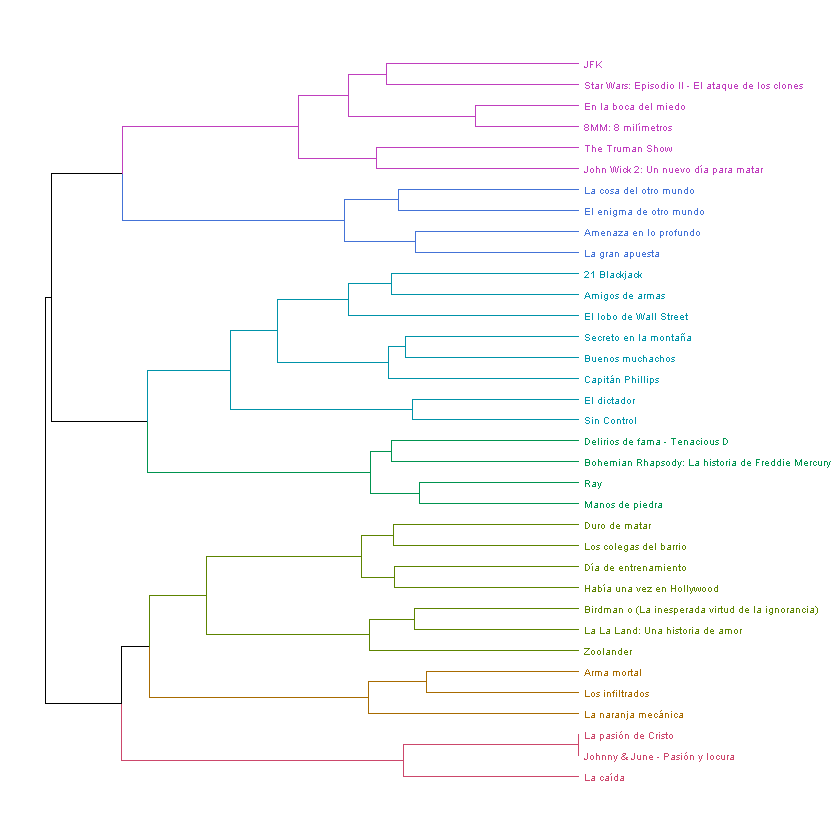

In [21]:
# Sub-árbol
dend   <- cut(as.dendrogram(hc), h=1.9)
leaves <- dend$lower[[3]]

# Gráfico con títulos de películas (se eligen 7 grupos)
par(mar=c(1,1,1,10))
leaves %>% 
  set("labels_cex", 0.5) %>%
  set("labels_col", k=7) %>%
  set("branches_k_color", k=7) %>%
  set_labels(labels[order.dendrogram(leaves)]) %>%
  plot(horiz=TRUE, axes=FALSE)

Dividiendo el sub-árbol en 7 sectores se observan grupos razonables, pero también algunas inconsistencias, por ejemplo, la película "Zoolander" se encuentra en el mismo grupo que "Duro de matar". Ahora se gráfica el mismo sub-árbol pero con los géneros correspondientes.

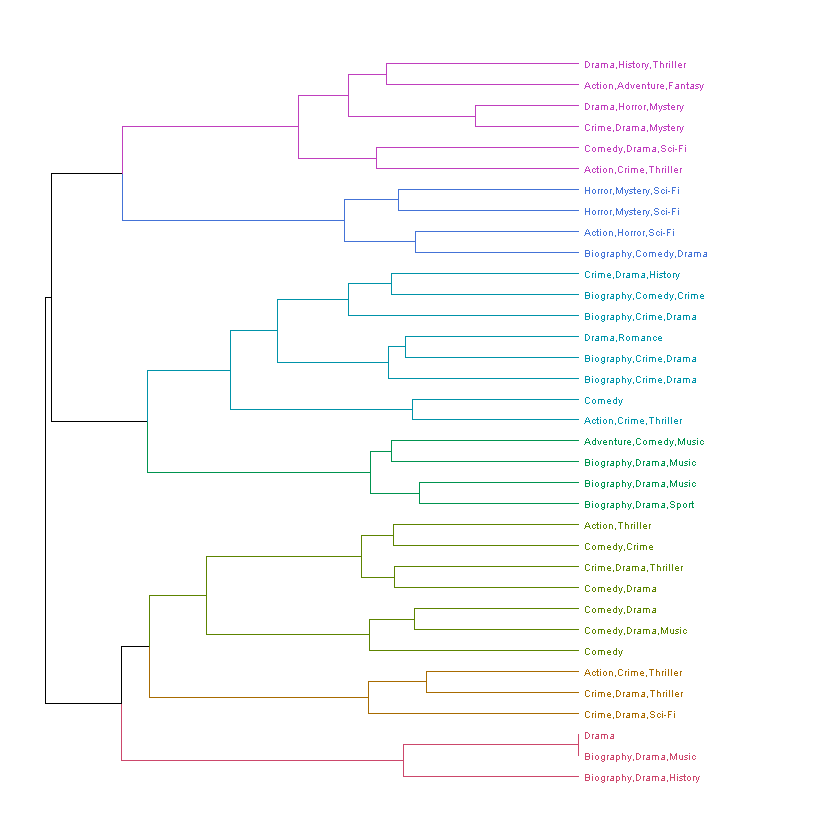

In [22]:
# Sub-árbol
dend   <- cut(as.dendrogram(hc), h=1.9)
leaves <- dend$lower[[3]]

# Gráfico con géneros de películas (se eligen 7 grupos)
par(mar=c(1,1,1,10))
leaves %>% 
  set("labels_cex", 0.5) %>%
  set("labels_col", k=7) %>%
  set("branches_k_color", k=7) %>%
  set_labels(genres[order.dendrogram(leaves)]) %>%
  plot(horiz=TRUE, axes=FALSE)

Desde el punto de vista de los géneros de películas el resultado también parece coherente aunque películas etiquetadas como biográficas fueron asignadas en distintos grupos.

## Kmeans
Para visualizar el rendimiento del algoritmo kmeans se proyecta la matriz tf-idf en 2 dimensiones con el méotodo t-SNE.

### Proyección en el plano (t-SNE)

In [23]:
# Reducción de la dimensión (método t-SNE)
tsne <- Rtsne(X = tfidf_matrix, is_distance = FALSE, dims = 2, perplexity = 30, theta = 0.5, max_iter = 500)

# Guardo proyecciones en 2D
dt_2D_tsne = as.data.frame(tsne$Y)

### Algoritmo

In [24]:
# Kmeans
km <- kmeans(scale(tfidf_matrix), centers = 8, nstart = 25)
str(km)

List of 9
 $ cluster     : Named int [1:300] 4 4 6 4 4 6 5 6 4 3 ...
  ..- attr(*, "names")= chr [1:300] "1" "2" "3" "4" ...
 $ centers     : num [1:8, 1:272] -0.2372 0.2104 0.0856 -0.0946 -0.2372 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:8] "1" "2" "3" "4" ...
  .. ..$ : chr [1:272] "famili" "futur" "high" "order" ...
 $ totss       : num 81328
 $ withinss    : num [1:8] 3707 3058 9066 50630 3243 ...
 $ tot.withinss: num 76245
 $ betweenss   : num 5083
 $ size        : int [1:8] 13 8 34 210 11 10 7 7
 $ iter        : int 5
 $ ifault      : int 0
 - attr(*, "class")= chr "kmeans"


In [25]:
# Agrego características al dataset
dt_2D_tsne$cl_kmeans <- factor(km$cluster)
dt_2D_tsne$labels    <- labels
dt_2D_tsne$genres    <- genres

In [26]:
# Tomo una muestra de 50 películas
set.seed(123)
sample <- dt_2D_tsne[sample(1:300, 50),]

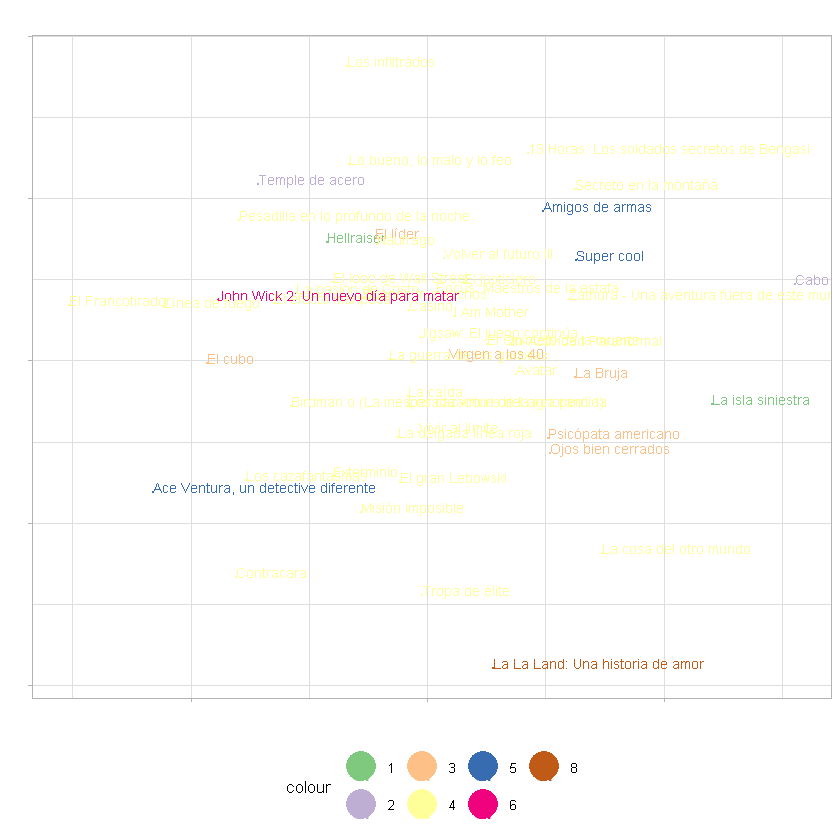

In [27]:
# Gráfico 2D con títulos de películas
ggplot(sample, aes_string(x="V1", y="V2", color=sample$cl_kmeans)) +
geom_point(size=0.25) +
geom_text(aes(label=sample$labels), size = 3, hjust=0, vjust=0) +
guides(colour=guide_legend(override.aes=list(size=8))) +
xlab("") + 
ylab("") +
ggtitle("") +
theme_light(base_size=10) +
theme(axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      legend.direction = "horizontal", 
      legend.position = "bottom",
      legend.box = "horizontal") + 
scale_colour_brewer(palette = "Accent") 

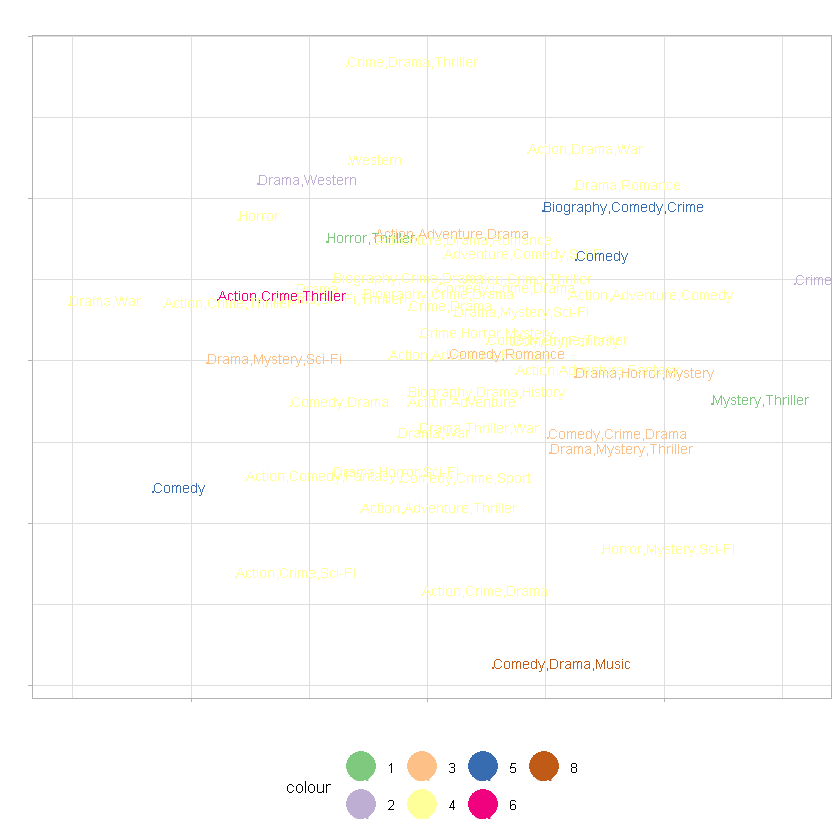

In [28]:
# Gráfico 2D con géneros de películas
ggplot(sample, aes_string(x="V1", y="V2", color=sample$cl_kmeans)) +
geom_point(size=0.25) +
geom_text(aes(label=sample$genres), size = 3, hjust=0, vjust=0) +
guides(colour=guide_legend(override.aes=list(size=8))) +
xlab("") + 
ylab("") +
ggtitle("") +
theme_light(base_size=10) +
theme(axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      legend.direction = "horizontal", 
      legend.position = "bottom",
      legend.box = "horizontal") + 
scale_colour_brewer(palette = "Accent") 

En este caso es más difícil ver la relación entre los grupos de pelícluas en comparación con los gráficos de los clústeres jerárquicos. Es posible que la representación en el plano no sea buena. Se prueba representar los grupos en un gráfico 3D.

In [29]:
# Reducción de dimensiones (método t-SNE)
tsne_3d <- Rtsne(X = tfidf_matrix, is_distance = FALSE, dims = 3, perplexity = 20,  theta = 0.5, max_iter = 500)

# Guardo proyecciones en 3D
dt_3D_tsne <-  as.data.frame(tsne_3d$Y)
colnames(dt_3D_tsne) <- c("dim_1", "dim_2", "dim_3")

dt_3D_tsne$cl_kmeans <- factor(km$cluster)
dt_3D_tsne$labels    <- labels
dt_3D_tsne$genres    <- genres

In [30]:
# Tomo una muestra de 50 películas
set.seed(123)
sample_3d <- dt_3D_tsne[sample(1:300, 30),]

Warning message in data.matrix(x):
"NAs introducidos por coerción"Warning message in data.matrix(x):
"NAs introducidos por coerción"

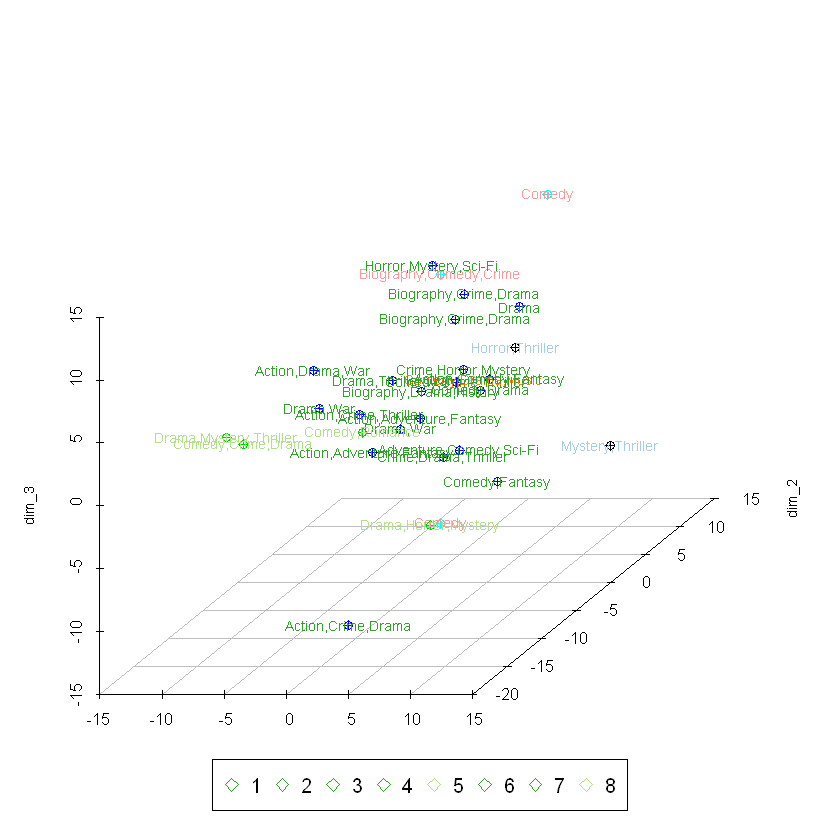

In [31]:
# Gráfico 3D con géneros de películas

colores <- brewer.pal(n = 8, name = "Paired")
colores <- colores[as.numeric(sample_3d$cl_kmeans)]

s3d <- scatterplot3d(sample_3d,
              pch = 10, color = colores, cex.lab = 0.7,
              grid = TRUE, box = FALSE)

text(s3d$xyz.convert(sample_3d[,1:3]), 
     labels = sample_3d$genres, cex= 0.7,  col = colores)

legend("bottom", legend = levels(sample_3d$cl_kmeans),
      col = colores, pch = 5,
      inset = -0.15, xpd = TRUE, horiz = TRUE)

Tampoco es fácil distinguir los grupos en un gráfico 3D pero se pueden apreciar algunas relaciones que tienen cierta coherencia.

## Dbscan
Del mismo modo en que se trabajó con kmeans ahora se prueba con el algoritmo Dbscan, en este caso, utilizando la matriz de distancia como entrada.

### Proyección en el plano (t-SNE)

In [32]:
# Reducción de la dimensión (método t-SNE)
tsne_db <- Rtsne(X = dist_matrix, is_distance = TRUE, dims = 2, perplexity = 30,
              theta = 0.5, max_iter = 500)

# Guardo proyecciones en 2D
dt_2D_tsne_db = as.data.frame(tsne_db$Y)

### Algoritmo

In [33]:
# Kmeans
db <- hdbscan(dist_matrix, minPts = 5) 

In [34]:
# Agrego características al dataset
dt_2D_tsne_db$cl_dbscan <- factor(db$cluster)
dt_2D_tsne_db$labels    <- labels
dt_2D_tsne_db$genres    <- genres

In [35]:
# Tomo una muestra de 50 películas
set.seed(123)
sample_db <- dt_2D_tsne_db[sample(1:300, 100),]

In [36]:
# Cantidad de individuos en cada grupo
table(sample_db$cl_dbscan)


 0  1  2  3  4 
86  4  3  3  4 

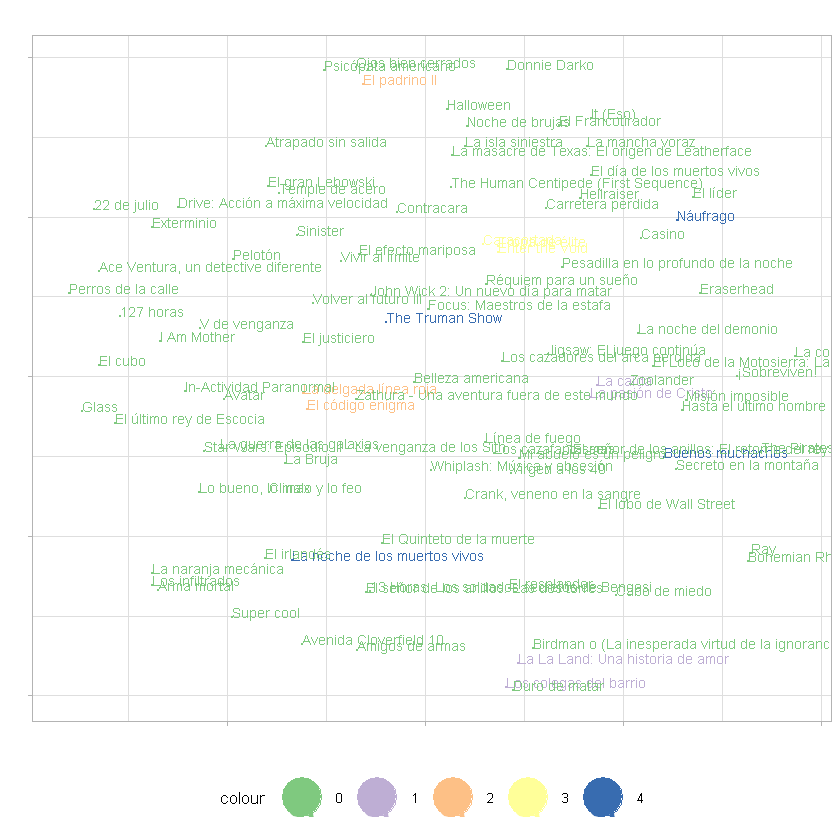

In [37]:
# Gráfico 2D con títulos de películas
ggplot(sample_db, aes_string(x="V1", y="V2", color=sample_db$cl_dbscan)) +
geom_point(size=0.25) +
geom_text(aes(label=sample_db$labels), size = 3, hjust=0, vjust=0) +
guides(colour=guide_legend(override.aes=list(size=11))) +
xlab("") + 
ylab("") +
ggtitle("") +
theme_light(base_size=10) +
theme(axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      legend.direction = "horizontal", 
      legend.position = "bottom",
      legend.box = "horizontal") + 
scale_colour_brewer(palette = "Accent") 

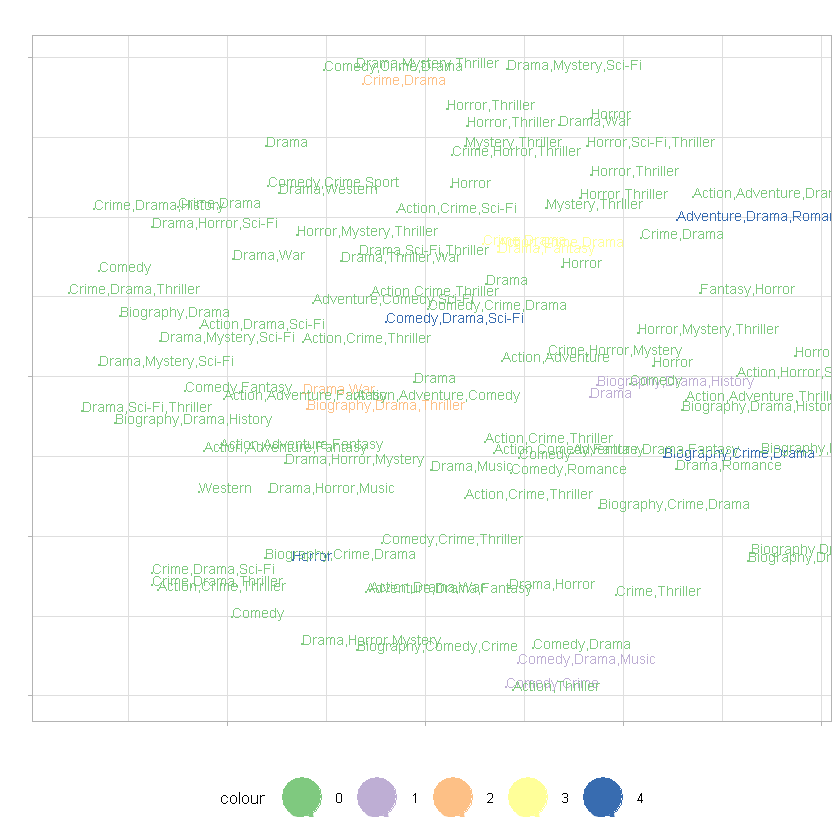

In [38]:
# Gráfico 2D con títulos de géneros
ggplot(sample_db, aes_string(x="V1", y="V2", color=sample_db$cl_dbscan)) +
geom_point(size=0.25) +
geom_text(aes(label=sample_db$genre), size = 3, hjust=0, vjust=0) +
guides(colour=guide_legend(override.aes=list(size=11))) +
xlab("") + 
ylab("") +
ggtitle("") +
theme_light(base_size=10) +
theme(axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      legend.direction = "horizontal", 
      legend.position = "bottom",
      legend.box = "horizontal") + 
scale_colour_brewer(palette = "Accent") 


####  Como conclusión se puede decir que para los datos analizados el agrupamiento jerárquico fue más eficaz en cuanto a la interpretación gráfica de los resultados, no obstante, no significa que los otros algoritmos sean peores en términos de clasificación, sino que tal vez la representación de los clústers en un esquema de 2 o 3 dimensiones no es la indicada.